Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Libraries

In [ ]:
import os
import numpy as np
import cv2

Define Image and Mask Directories

In [ ]:
image_dir = '/content/drive/MyDrive/LiverSegmentation/images'
mask_dir = '/content/drive/MyDrive/LiverSegmentation/masks'


Load More Libraries

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models


Load Image and Mask Filenames

In [ ]:

image_dir = '/content/drive/MyDrive/images'
mask_dir = '/content/drive/MyDrive/masks'

image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))



Loading and Preprocessing Images and Masks

In [ ]:
images = []
masks = []

for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, mask_file)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is not None and mask is not None:
        img = cv2.resize(img, (128, 128))
        mask = cv2.resize(mask, (128, 128))

        images.append(img)
        masks.append(mask)
    else:
        print(f"Skipped {img_file} or {mask_file} due to read error.")


Skipped .ipynb_checkpoints or .ipynb_checkpoints due to read error.


Converting to NumPy Arrays and Normalizing

In [ ]:
images = np.array(images, dtype='float32') / 255.0
masks = (np.array(masks) > 127).astype('float32')  # binary mask

# Expand dims to add channel
images = np.expand_dims(images, axis=-1)
masks = np.expand_dims(masks, axis=-1)

print(f"Image shape: {images.shape}, Mask shape: {masks.shape}")

Image shape: (502, 128, 128, 1), Mask shape: (502, 128, 128, 1)


Split Dataset

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

Define U-Net Model

In [ ]:
def unet_model(input_size=(128, 128, 1)):
    inputs = layers.Input(input_size)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D()(c3)
    u1 = layers.Concatenate()([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)

    model = models.Model(inputs, outputs)
    return model

Compile and Train Model

In [ ]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=16)

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8565 - loss: 0.4415 - val_accuracy: 0.9462 - val_loss: 0.1774
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9639 - loss: 0.1212 - val_accuracy: 0.9462 - val_loss: 0.1413
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9660 - loss: 0.1022 - val_accuracy: 0.9462 - val_loss: 0.1263
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9679 - loss: 0.0936 - val_accuracy: 0.9462 - val_loss: 0.1390
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9613 - loss: 0.1064 - val_accuracy: 0.9462 - val_loss: 0.1126


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 669ms/step


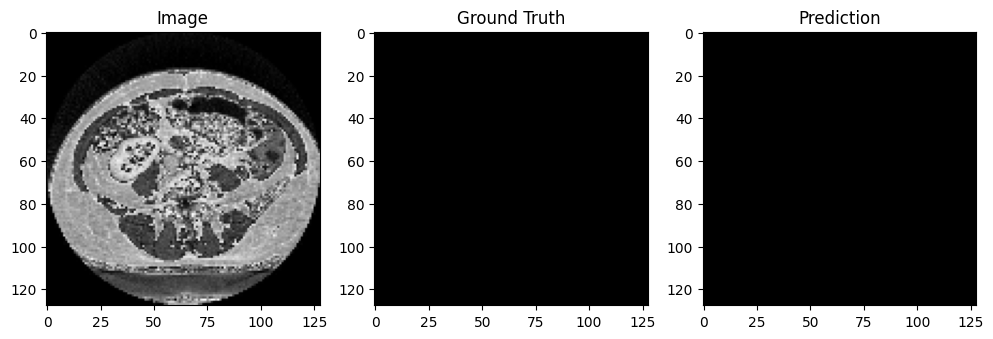

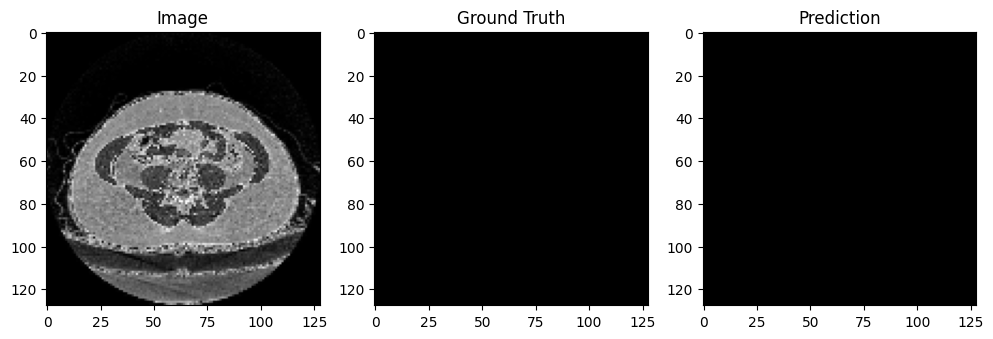

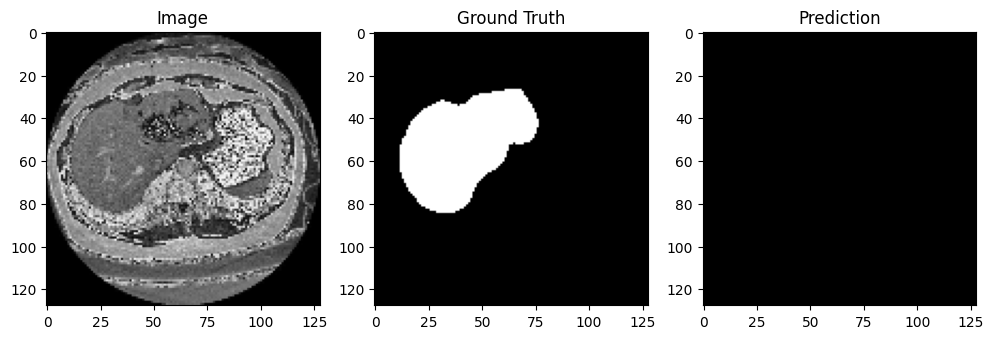

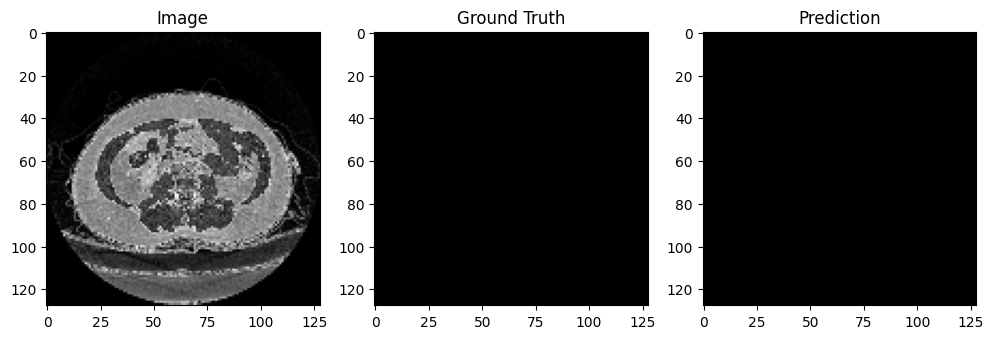

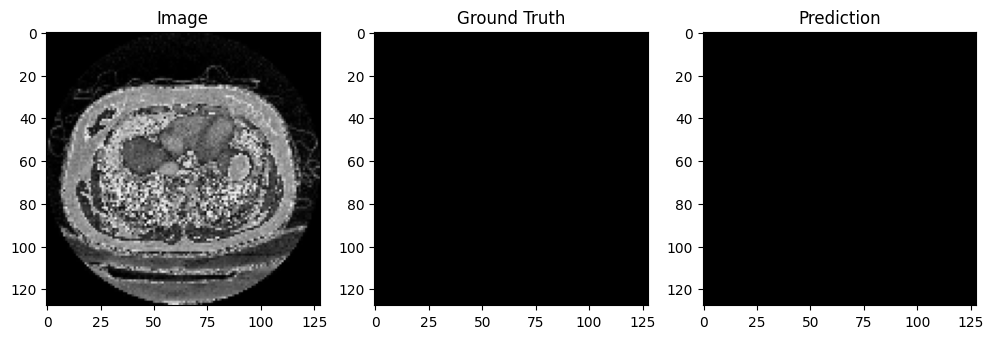

In [ ]:
def plot_sample(img, mask, pred=None):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title("Image")
    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.subplot(1, 3, 3)
    if pred is not None:
        plt.imshow(pred.squeeze() > 0.5, cmap='gray')
        plt.title("Prediction")
    plt.show()

preds = model.predict(x_val)
n = min(5, len(x_val))  # avoid going out of bounds

for i in range(n):
    plot_sample(x_val[i], y_val[i], preds[i])


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=16)


Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9626 - loss: 0.0964 - val_accuracy: 0.9462 - val_loss: 0.1008
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9644 - loss: 0.0765 - val_accuracy: 0.9462 - val_loss: 0.1148
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9717 - loss: 0.0766 - val_accuracy: 0.9644 - val_loss: 0.0863
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9748 - loss: 0.0622 - val_accuracy: 0.9629 - val_loss: 0.0835
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9629 - loss: 0.0908 - val_accuracy: 0.9639 - val_loss: 0.0837
